# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [1]:
import math

import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)

## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts)
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [2]:
from collections import defaultdict
from sklearn.base import BaseEstimator, ClusterMixin

NOISE = 0

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, eps=0.5, min_samples=3):
        """
        Please add necessary algoritm parameters to class constructor.
        @param[in] eps (float): Радиус сферы вокруг объекта
        @param[in] min_samples (int): Минимальное кол-во других объектов внутри сферы для признания объекта корневым
        """
        self.eps = eps
        self.min_samples = min_samples
        self.clusters = defaultdict(list)
        self.mean_distances = []
        self._distances = defaultdict(list)
        self._cluster_id = NOISE + 1
        self._visited = set()
        self._belong = set()
        self._noise = set()
        
    def fit(self, X, y=None):
        """
        Use data matrix x to compute model parameters
        """
        if not self.clusters:
            self._dbscan(X)
        return self
    
    def predict(self, X):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        predicted = []
        for k, v in self.clusters.items():
            for i in range(len(v)):
                predicted.append(k)
        return np.array(predicted)
    
    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X)

    def _dbscan(self, X):
        for i in range(X.shape[0]):
            if i in self._visited:
                continue
            self._visited.add(i)
            neighbours = self._neighbours(X, i)
            if len(neighbours) < self.min_samples:
                self._noise.add(i)
            else:
                self._belong.add(i)
                self._expand_cluster(X, neighbours, i)
        if self._noise:
            self.clusters[NOISE].extend(X[j] for j in self._noise)
        self.mean_distances.sort()

    def _expand_cluster(self, X, neighbours, x_i):
        self.clusters[self._cluster_id] = [X[x_i],]
        while len(neighbours) > 0:
            x_j = neighbours.pop()
            if x_j not in self._visited:
                self._visited.add(x_j)
                ex_neighbours = self._neighbours(X, x_j)
                if len(ex_neighbours) >= self.min_samples:
                    neighbours.extend(ex_neighbours)
            if x_j not in self._belong:
                self._belong.add(x_j)
                self.clusters[self._cluster_id].append(X[x_j])
                if x_j in self._noise:
                    self._noise.remove(x_j)
        self._cluster_id += 1

    def _calc_mean_distances(self, x_i):
        if x_i in self._distances:
            nearest = sorted(self._distances[x_i])[:self.min_samples]
            mean = np.mean(nearest)
            self.mean_distances.append(mean)
        
    def _neighbours(self, X, x_i):
        neighbours = []
        for i in range(X.shape[0]):
            dist = self._dist(X[x_i], X[i])
            if i != x_i:
                if dist < self.eps:
                    neighbours.append(i)
                self._distances[x_i].append(dist)
        self._calc_mean_distances(x_i)
        return neighbours

    def _dist(self, x, y):
        return self._euclidean_distance(x, y)

    @staticmethod
    def _euclidean_distance(x, y):
        return math.sqrt(np.power(x - y, 2).sum())

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

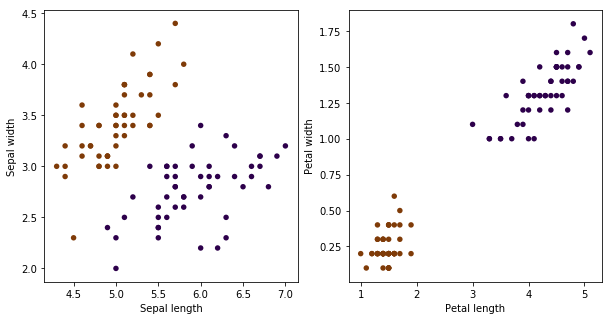

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [4]:
pred_iris = Clustering(eps=0.65, min_samples=3).fit_predict(x_iris)
# print(pred_iris)
# print(y_iris)
print('Adjusted Rand index for iris is: %.2f' % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

Попробуем найти оптимальный eps и min_pts для 150 ирисов.

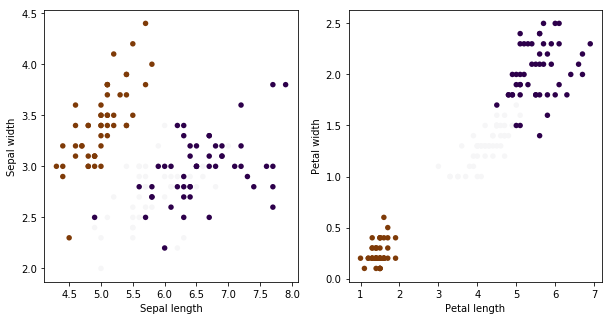

In [5]:
x = iris.data[:150]
y = iris.target[:150]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x[:, 0], x[:, 1], c=y, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x[:, 2], x[:, 3], c=y, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Как видно, добавился еще 3-ий кластер

Попробуем подобрать оптимальный eps для min_pts равном 3, 4, 5, 6. Для этого построим графики и попробуем провести анализ.

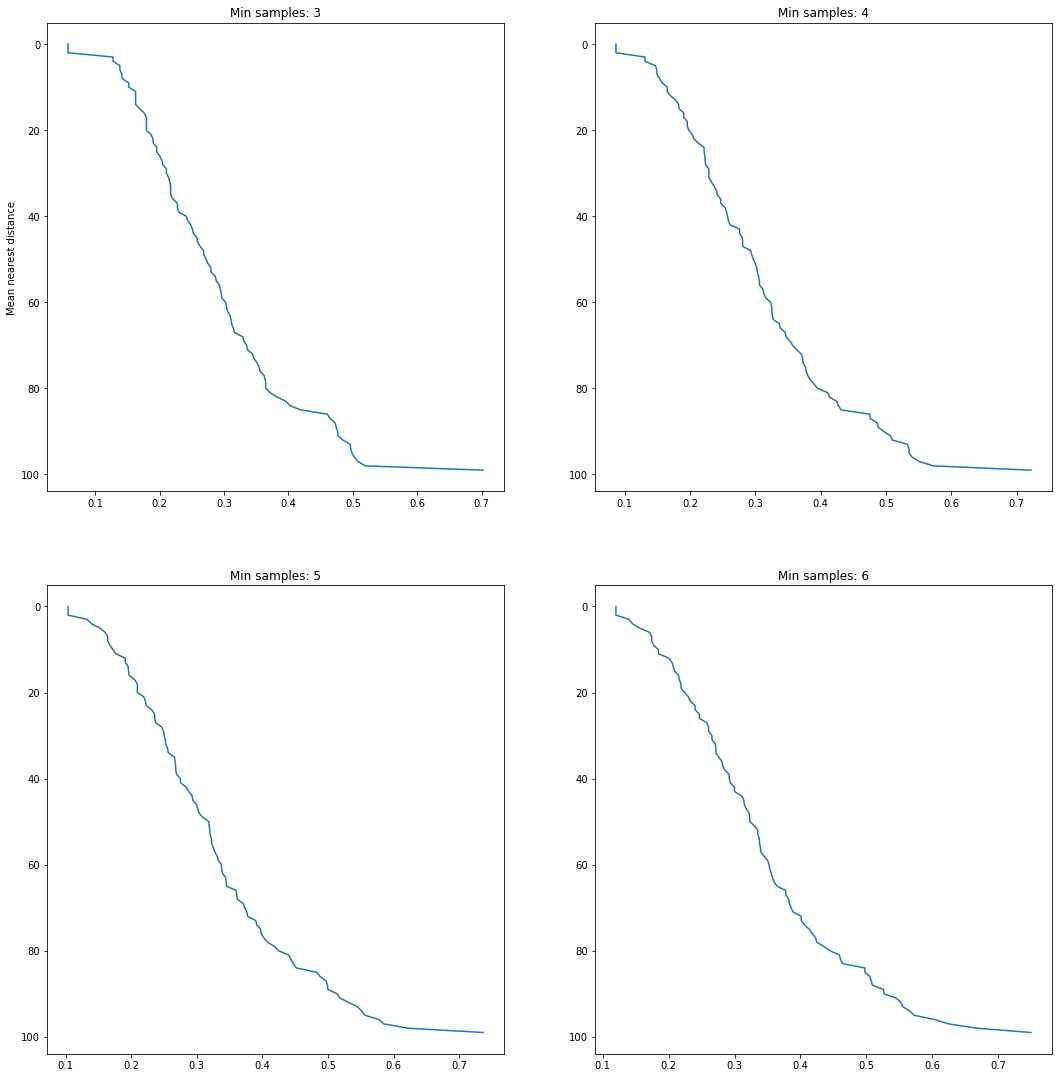

In [7]:
fig = plt.figure(figsize=(18, 50))
j = 0
for i in [3, 4, 5, 6]:
    cls = Clustering(min_samples=i)
    cls.fit(x_iris)
    ax = fig.add_subplot(5, 2, j+1)
    plt.plot(cls.mean_distances, list(range(len(cls.mean_distances))))
    plt.title('Min samples: {}'.format(i))
    if j == 0:
        plt.ylabel('Mean nearest distance')
    plt.gca().invert_yaxis();
    j += 1

На графиках видно, что максимальные изломы довольно сильно варьируются и примерно составляют: для min_pts=3 - 0.36, для min_pts=4 - 0.41, для min_pts=5 - 0.43, для min_pts=6 - 0.46. Чтобы не слишком много гадать, проверим их все разом.

In [8]:
def quality(x, y):
    return smt.adjusted_rand_score(x, y)

for i in [3, 4, 5, 6, 7]:
    for eps in [0.36, 0.41, 0.43, 0.46]:
        pred = Clustering(eps=eps, min_samples=i).fit_predict(x)
        print('Quality of prediction (for eps {0:.2f} and min_pts {1}) is {2:.2f}'.format(
            eps, i, quality(pred, y))
        )
    print()

Quality of prediction (for eps 0.36 and min_pts 3) is 0.70
Quality of prediction (for eps 0.41 and min_pts 3) is 0.61
Quality of prediction (for eps 0.43 and min_pts 3) is 0.56
Quality of prediction (for eps 0.46 and min_pts 3) is 0.56

Quality of prediction (for eps 0.36 and min_pts 4) is 0.63
Quality of prediction (for eps 0.41 and min_pts 4) is 0.65
Quality of prediction (for eps 0.43 and min_pts 4) is 0.60
Quality of prediction (for eps 0.46 and min_pts 4) is 0.58

Quality of prediction (for eps 0.36 and min_pts 5) is 0.52
Quality of prediction (for eps 0.41 and min_pts 5) is 0.65
Quality of prediction (for eps 0.43 and min_pts 5) is 0.58
Quality of prediction (for eps 0.46 and min_pts 5) is 0.58

Quality of prediction (for eps 0.36 and min_pts 6) is 0.50
Quality of prediction (for eps 0.41 and min_pts 6) is 0.69
Quality of prediction (for eps 0.43 and min_pts 6) is 0.65
Quality of prediction (for eps 0.46 and min_pts 6) is 0.59

Quality of prediction (for eps 0.36 and min_pts 7) i

Как видно, самый точный прогноз получился для eps=0.360 и min_pts=3. Для остальных случаев, прогнозы оказались недостаточно точны, возможно, стоит строить более точные графики, потому что от небольшого смещения в несколько десятых, может сильно просесть точность прогноза.

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

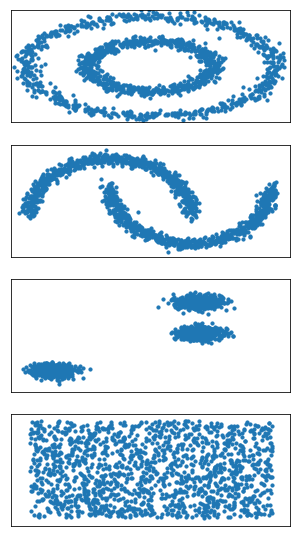

In [9]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

In [10]:
k = 5
cls = Clustering()
y = cls.fit_predict(x)